What happened here is I downloaded and compiled conga on openstack, and then ran the script `hack2.sh` stored in this directory to create an input file for it. The input file is a subset of the cellranger `all_contig_annotations.csv` file, filtering to just the cells that actually appear in Chenqu's object. The barcode and contig name fields then have the appropriate GEX ID prepended, matching Chenqu's nomenclature in the object. The relationship between GEX and VDJ ID is guided via a `meta.csv` file also stored in the folder.

Once the input file was created, conga was ran via `python3 setup_10x_for_conga.py --filtered_contig_annotations_csvfile conga.csv --organism human`, producing messages stored in `conga-run-printout`

In [1]:
import anndata
import pandas as pd
import scanpy as sc
import numpy as np

sc.settings.set_figure_params(dpi=80)

Two files were copied over for analysis:
- `conga_tcrdist_clones_AB.dist_50_kpcs`, the PC coordinates for the identified clonotypes; renamed to `conga-pcs.tsv`
- `conga_tcrdist_clones.tsv.barcode_mapping.tsv`, the actual barcodes that make up the clonotypes; renamed to `conga_tcrdist_clones.tsv.barcode_mapping.tsv`

Shave off a surplus column from the PC file, and set the index to be the clonotype. Time for the cell assignments!

In [2]:
conga = pd.read_table("conga-pcs.tsv", sep=" ", header=None).iloc[:,1:].set_index(1)
conga

,2,3,4,5,6,7,8,9,10,11,...,42,43,44,45,46,47,48,49,50,51
1,,,,,,,,,,,,,,,,,,,,,
clonotype1314,-0.135811,-0.046000,0.122711,-0.031451,-0.136170,0.056991,0.001262,0.041435,-0.043045,-0.051900,...,0.057810,-0.030510,0.100740,-0.046276,0.007025,-0.004047,0.037373,-0.022633,-0.044709,0.012785
clonotype1326,-0.135521,-0.160513,-0.018748,0.022008,0.032348,0.076690,0.020586,-0.028414,0.011464,0.137583,...,-0.007461,0.001315,0.017268,0.028976,-0.008171,-0.085723,0.007170,0.031609,-0.065966,-0.069854
clonotype1365,-0.065021,0.044626,0.018651,0.189092,-0.002820,0.000689,-0.011216,-0.040674,-0.026607,-0.047341,...,0.036381,0.045447,-0.066866,-0.034716,0.076206,0.105047,0.031048,0.012522,0.042033,0.003483
clonotype1373,-0.038554,-0.048914,0.116654,-0.028968,-0.137889,0.045513,0.019559,-0.021847,0.002797,-0.098356,...,0.060085,0.022995,0.024571,-0.007498,-0.017527,0.084620,0.039419,0.034630,0.038688,-0.027689
clonotype1385,-0.060139,-0.120214,-0.084528,0.048819,-0.073054,0.050844,-0.039621,-0.056507,0.087982,0.041024,...,-0.018834,-0.053167,-0.027831,0.000593,-0.015866,-0.044760,-0.036727,0.024186,-0.035335,-0.026555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
clonotype850,-0.151608,-0.103199,0.091921,0.057323,0.000947,0.046248,-0.023849,-0.028024,-0.091071,0.003054,...,0.022477,0.012152,-0.004658,-0.003256,0.034901,0.147700,0.013700,0.008087,-0.012579,0.009028
clonotype869,-0.041308,-0.110076,-0.010542,0.001351,-0.172595,0.114527,-0.081276,-0.135696,0.061359,0.026908,...,0.028980,0.017746,0.074985,0.003391,-0.019348,-0.015162,0.023126,-0.025830,-0.024589,0.036926
clonotype900,-0.038262,-0.033139,-0.064670,0.113120,-0.063638,-0.039740,-0.056923,0.018244,0.087001,-0.087391,...,-0.047398,0.042280,0.146290,-0.069348,-0.003890,-0.016184,-0.052002,-0.044751,-0.085426,-0.004893


Of note, most of these are singleton assignments. Occasionally there will be a pair. I took the first one for the purposes of digging up the annotation, which should be firmly good enough.

In [3]:
cells = pd.read_table("conga-cells.tsv", index_col=0)
#oh also there are -1s at the end of cell barcodes. kick those
cells['barcodes'] = [i.split(",")[0].replace("-1","") for i in cells['barcodes']]
cells

,barcodes
clone_id,
clonotype1314,FCAImmP7803034-TGCTGCTTCTGTTTGT
clonotype1326,FCAImmP7851891-TGCTGCTTCGGTTAAC
clonotype1365,FCAImmP7803035-AGTGAGGGTAAACACA
clonotype1373,Human_colon_16S8159186-CGTGTCTTCTTGTACT
clonotype1385,FCAImmP7803034-GATTCAGGTCTGATTG
...,...
clonotype850,FCAImmP7579231-TCACAAGAGAATGTGT
clonotype869,FCAImmP7803035-GCCTCTAAGAATAGGG
clonotype900,FCA_gut8015061-GTCAAGTGTGCCTTGG


Is our index the same?

In [4]:
np.all(cells.index == conga.index)

True

It is! Jolly good! Rename the clonotypes to the barcodes.

In [5]:
conga.index = cells['barcodes']
conga

,2,3,4,5,6,7,8,9,10,11,...,42,43,44,45,46,47,48,49,50,51
barcodes,,,,,,,,,,,,,,,,,,,,,
FCAImmP7803034-TGCTGCTTCTGTTTGT,-0.135811,-0.046000,0.122711,-0.031451,-0.136170,0.056991,0.001262,0.041435,-0.043045,-0.051900,...,0.057810,-0.030510,0.100740,-0.046276,0.007025,-0.004047,0.037373,-0.022633,-0.044709,0.012785
FCAImmP7851891-TGCTGCTTCGGTTAAC,-0.135521,-0.160513,-0.018748,0.022008,0.032348,0.076690,0.020586,-0.028414,0.011464,0.137583,...,-0.007461,0.001315,0.017268,0.028976,-0.008171,-0.085723,0.007170,0.031609,-0.065966,-0.069854
FCAImmP7803035-AGTGAGGGTAAACACA,-0.065021,0.044626,0.018651,0.189092,-0.002820,0.000689,-0.011216,-0.040674,-0.026607,-0.047341,...,0.036381,0.045447,-0.066866,-0.034716,0.076206,0.105047,0.031048,0.012522,0.042033,0.003483
Human_colon_16S8159186-CGTGTCTTCTTGTACT,-0.038554,-0.048914,0.116654,-0.028968,-0.137889,0.045513,0.019559,-0.021847,0.002797,-0.098356,...,0.060085,0.022995,0.024571,-0.007498,-0.017527,0.084620,0.039419,0.034630,0.038688,-0.027689
FCAImmP7803034-GATTCAGGTCTGATTG,-0.060139,-0.120214,-0.084528,0.048819,-0.073054,0.050844,-0.039621,-0.056507,0.087982,0.041024,...,-0.018834,-0.053167,-0.027831,0.000593,-0.015866,-0.044760,-0.036727,0.024186,-0.035335,-0.026555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCAImmP7579231-TCACAAGAGAATGTGT,-0.151608,-0.103199,0.091921,0.057323,0.000947,0.046248,-0.023849,-0.028024,-0.091071,0.003054,...,0.022477,0.012152,-0.004658,-0.003256,0.034901,0.147700,0.013700,0.008087,-0.012579,0.009028
FCAImmP7803035-GCCTCTAAGAATAGGG,-0.041308,-0.110076,-0.010542,0.001351,-0.172595,0.114527,-0.081276,-0.135696,0.061359,0.026908,...,0.028980,0.017746,0.074985,0.003391,-0.019348,-0.015162,0.023126,-0.025830,-0.024589,0.036926
FCA_gut8015061-GTCAAGTGTGCCTTGG,-0.038262,-0.033139,-0.064670,0.113120,-0.063638,-0.039740,-0.056923,0.018244,0.087001,-0.087391,...,-0.047398,0.042280,0.146290,-0.069348,-0.003890,-0.016184,-0.052002,-0.044751,-0.085426,-0.004893


Import cell type annotation.

In [6]:
#adata = sc.read("/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/write/DP_cell_adata.h5ad")

In [6]:
# downloaded from https://developmental.cellatlas.io/fetal-immune
obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col = 0) 

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Construct an object for the conga results, store the cell barcodes as the obs names as we're gonna need that in a sec.

In [7]:
bdata = anndata.AnnData(conga)
bdata.obs_names = conga.index
bdata.obs

<ipython-input-7-b48efb01a614>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  bdata = anndata.AnnData(conga)
/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


""
barcodes
FCAImmP7803034-TGCTGCTTCTGTTTGT
FCAImmP7851891-TGCTGCTTCGGTTAAC
FCAImmP7803035-AGTGAGGGTAAACACA
Human_colon_16S8159186-CGTGTCTTCTTGTACT
FCAImmP7803034-GATTCAGGTCTGATTG
...
FCAImmP7579231-TCACAAGAGAATGTGT
FCAImmP7803035-GCCTCTAAGAATAGGG
FCA_gut8015061-GTCAAGTGTGCCTTGG


Stash the conga derived PCs in the object, and copy over the annotation.

In [8]:
bdata.obsm["X_pca"] = conga.values
bdata.obs["anno_lvl_2_final_clean"] = obs.loc[bdata.obs_names, "anno_lvl_2_final_clean"]

Quick sanity check that nothing got borked underway.

In [9]:
bdata.obs

,anno_lvl_2_final_clean
barcodes,
FCAImmP7803034-TGCTGCTTCTGTTTGT,CD4+T
FCAImmP7851891-TGCTGCTTCGGTTAAC,DP(Q)_T
FCAImmP7803035-AGTGAGGGTAAACACA,CD4+T
Human_colon_16S8159186-CGTGTCTTCTTGTACT,CD4+T
FCAImmP7803034-GATTCAGGTCTGATTG,CD4+T
...,...
FCAImmP7579231-TCACAAGAGAATGTGT,DP(P)_T
FCAImmP7803035-GCCTCTAAGAATAGGG,CD4+T
FCA_gut8015061-GTCAAGTGTGCCTTGG,CD4+T


In [10]:
obs.loc[bdata.obs_names, "anno_lvl_2_final_clean"]

barcodes
FCAImmP7803034-TGCTGCTTCTGTTTGT              CD4+T
FCAImmP7851891-TGCTGCTTCGGTTAAC            DP(Q)_T
FCAImmP7803035-AGTGAGGGTAAACACA              CD4+T
Human_colon_16S8159186-CGTGTCTTCTTGTACT      CD4+T
FCAImmP7803034-GATTCAGGTCTGATTG              CD4+T
                                            ...   
FCAImmP7579231-TCACAAGAGAATGTGT            DP(P)_T
FCAImmP7803035-GCCTCTAAGAATAGGG              CD4+T
FCA_gut8015061-GTCAAGTGTGCCTTGG              CD4+T
Human_colon_16S8159186-CTCGGGAGTGTAATGA      CD4+T
FCAImmP7555860-GAGCAGAGTGATAAGT              CD8+T
Name: anno_lvl_2_final_clean, Length: 832, dtype: object

Yeah, we're good here. Visualise the PCA.

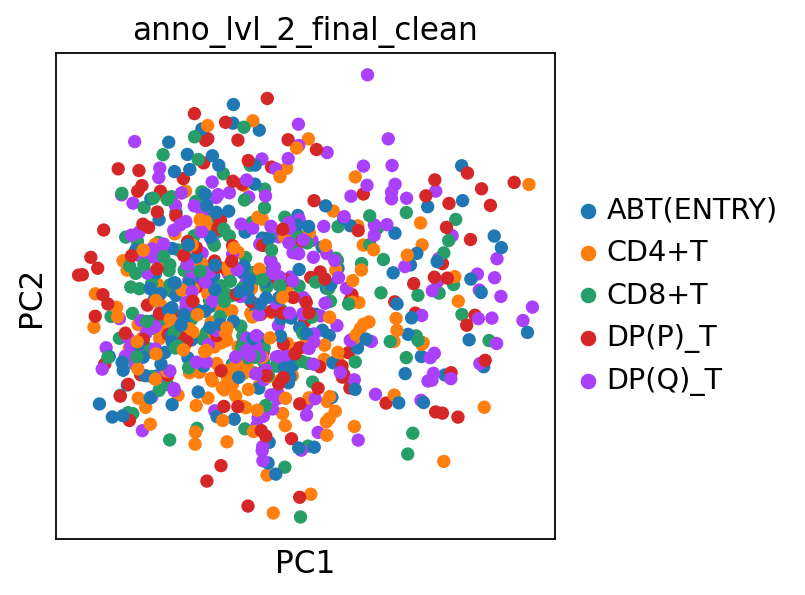

In [11]:
sc.pl.pca(bdata, color="anno_lvl_2_final_clean")

In [16]:
# set up subsets and colors
import seaborn as sns
ct_order = ['DP(P)_T','DP(Q)_T','ABT(ENTRY)','CD8+T','CD4+T']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette('colorblind'))[range(len(ct_order))]))
# figure directory
fig_path = '/home/jovyan/mount/gdrive/VDJ_collab/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

In [19]:
bdata.obs["anno_lvl_2_final_clean"] = bdata.obs["anno_lvl_2_final_clean"].cat.reorder_categories(ct_order)

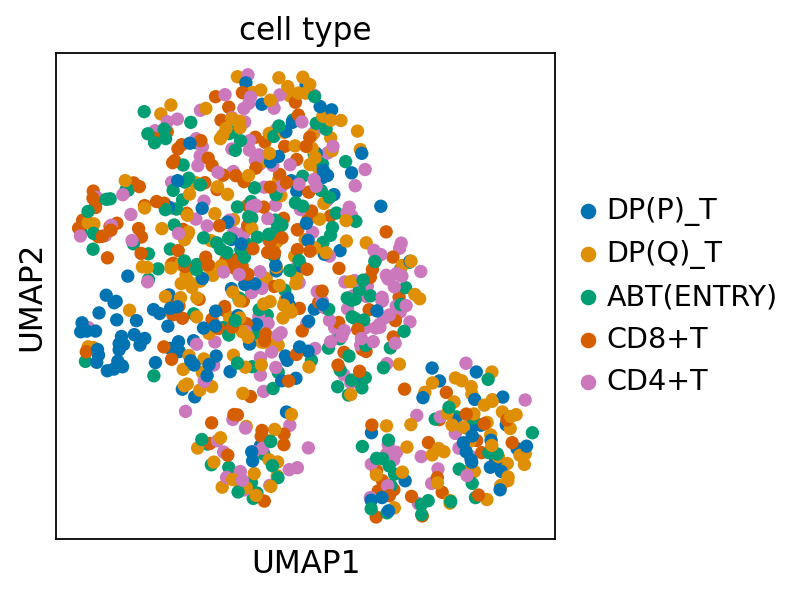

In [20]:
sc.pp.neighbors(bdata)
sc.tl.umap(bdata, random_state = 1712)
sc.pl.umap(bdata, color="anno_lvl_2_final_clean", title = 'cell type', palette = ct_color_map, save = 'conga.pdf')